In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
filename = 'colliders.csv'
data = np.loadtxt(filename,delimiter=',',dtype='Float64',skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [88]:
from planning_utils import create_grid, a_star, heuristic, Action, collinearity_prune
#from udacidrone.frame_utils import global_to_local, local_to_global

In [7]:
import utm
import numpy

def global_to_local(global_position, global_home):
    (east_home, north_home, _, _) = utm.from_latlon(global_home[1], global_home[0])
    (east, north, _, _) = utm.from_latlon(global_position[1], global_position[0])
    local_position = numpy.array([north-north_home, east-east_home, -(global_position[2]-global_home[2])])
    
    return local_position


def local_to_global(local_position, global_home):
    (east_home, north_home, zone_number, zone_letter) = utm.from_latlon(global_home[1], global_home[0])
    (lat, lon) = utm.to_latlon(east_home+local_position[1], north_home+local_position[0], zone_number, zone_letter)
    global_position = numpy.array([lon, lat, -(local_position[2]-global_home[2])])
    
    return global_position

In [30]:
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5
global_home = np.array([-122.39745, 37.79248, 0.0])
print("Global Home => [lon, lat, alt]: ",  global_home)
global_position = np.array([-122.3974512, 37.7924799, 0.147])
print('Global Position => [lon, lat, alt]: ',  global_home)
local_position = global_to_local(global_position, global_home)
print('Local Position  => [north, east, down]:',  local_position)

Global Home => [lon, lat, alt]:  [-122.39745   37.79248    0.     ]
Global Position => [lon, lat, alt]:  [-122.39745   37.79248    0.     ]
Local Position  => [north, east, down]: [-0.01177589 -0.10558296 -0.147     ]


In [32]:
grid, north_offset, east_offset  = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
print('Grid offset : ', (north_offset, east_offset))
grid_start_north = int(np.ceil(local_position[0] - north_offset))
grid_start_east = int(np.ceil(local_position[1] - east_offset))
grid_start = (grid_start_north, grid_start_east)
print('Grid star : ',  grid_start)

Grid offset :  (-316, -445)
Grid star :  (316, 445)


In [42]:
grid_goal_north = grid_start_north + 450
grid_goal_east = grid_start_east + 360
grid_goal = (grid_goal_north, grid_goal_east)
print('Grid goal : ', grid_goal)

goal_local_position_north = grid_goal_north + north_offset
goal_local_position_east = grid_goal_east + east_offset
goal_local_position = np.array([goal_local_position_north, goal_local_position_east, local_position[2]])
print('Goal Local Position => [north, east, down] : ',  goal_local_position)

goal_global_position = local_to_global(goal_local_position, global_home)
print('Global Global Position => [lon, lat, alt] : ',  goal_global_position)

Grid goal :  (766, 805)
Goal Local Position => [north, east, down] :  [ 4.50e+02  3.60e+02 -1.47e-01]
Global Global Position => [lon, lat, alt] :  [-122.39332818   37.79651474    0.147     ]


Found a path.
Path cost :  339964.08457529085
Waypoint count :  959


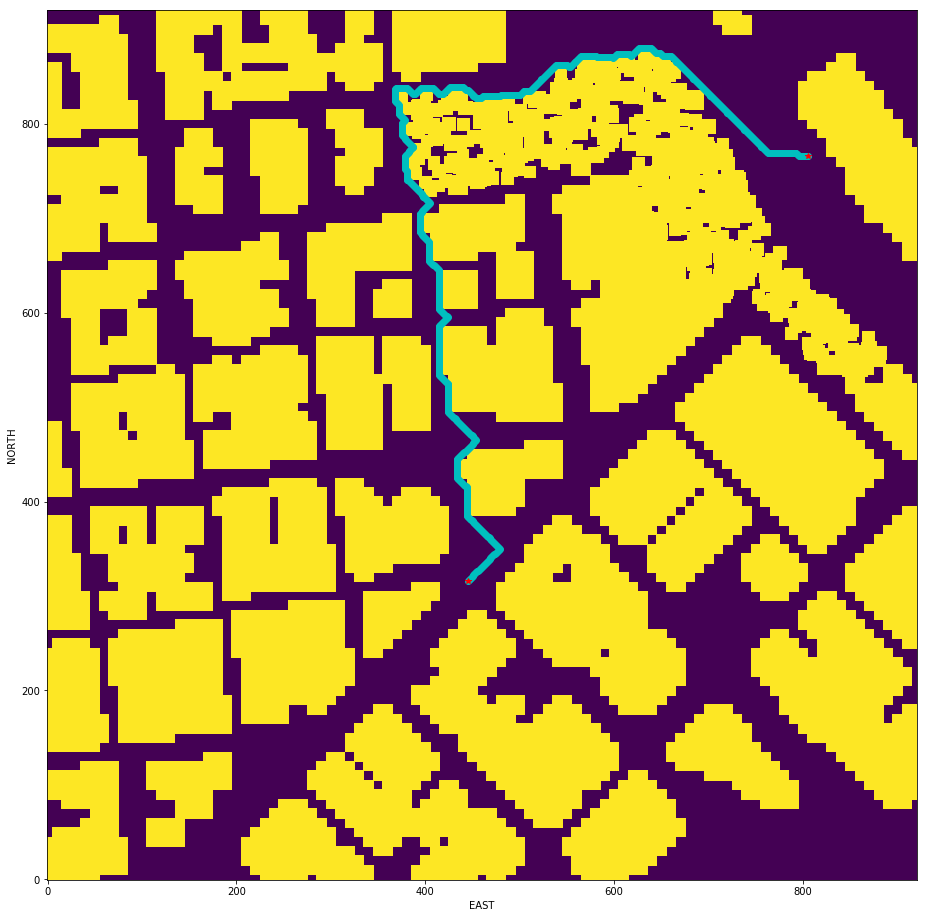

In [44]:
def visualize_path(g_start, g_goal, grid, n_offset, e_offset):
    """
    Visualize the path to get from `g_start` to `g_goal` defined by `waypoints` and the grid `g`
    """
    path, cost = a_star(grid, heuristic, grid_start, grid_goal)
    print('Path cost : ', cost)
    
    waypoints = np.array([[p[0] + n_offset, p[1] + e_offset, TARGET_ALTITUDE, 0] for p in path])
    print('Waypoint count : ',  waypoints.shape[0])
    
    fig = plt.figure(figsize=(16,16))   
    plt.imshow(grid, origin='lower') 
    plt.plot(g_start[1] + waypoints[:, 1], g_start[0] + waypoints[:, 0], 'oc')
    plt.plot(g_start[1], g_start[0], 'r*')    
    plt.plot(g_goal[1], g_goal[0], 'r*')
    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()
    
    return waypoints
    
wps = visualize_path(grid_start, grid_goal, grid, north_offset, east_offset)

In [ ]:
#Compare multiple goal locations

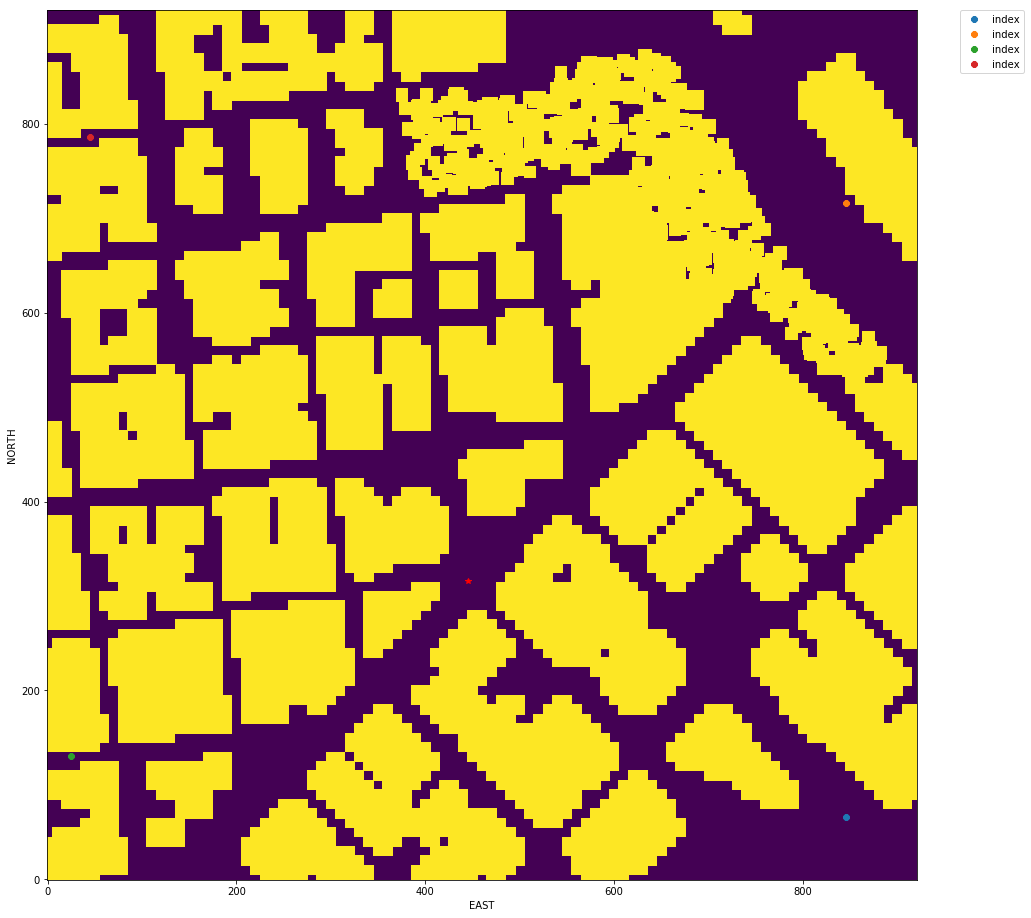

index:  (66, 845) [-122.39292549   37.7902035    -0.147     ]
index:  (716, 845) [-122.39287756   37.79606176   -0.147     ]
index:  (131, 25) [-122.40223348   37.79083694   -0.147     ]
index:  (786, 45) [-122.40195876   37.79673913   -0.147     ]


In [71]:
goals = [
    (grid_start[0] - 250, grid_start[1] + 400),
    (grid_start[0] + 400, grid_start[1] + 400),
    (grid_start[0] - 185, grid_start[1] - 420),
    (grid_start[0] + 470, grid_start[1] - 400)
]
fig = plt.figure(figsize=(20,16))   
plt.imshow(grid, origin='lower') 
plt.plot(grid_start[1], grid_start[0], 'r*')

for goal, index in zip(goals, range(4)):
    north, east = goal
    plt.plot(east, north, '8', label='index')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
global_goals = list(map(lambda g: local_to_global(np.array([g[0] + north_offset, g[1] + east_offset, 0.147]), global_home), goals))
for g, gg, index in zip(goals, global_goals, range(4)):
    print('index: ', g, gg)


In [72]:
import time

Found a path.
Goal:  [-122.39292549   37.7902035    -0.147     ] Cost:  88793.33556147506 Path Count:  404 Time:  13.143748998641968
Found a path.
Goal:  [-122.39287756   37.79606176   -0.147     ] Cost:  375644.3970721237 Path Count:  1000 Time:  51.251708030700684
Found a path.
Goal:  [-122.40223348   37.79083694   -0.147     ] Cost:  90852.68562785028 Path Count:  420 Time:  14.18639588356018
Found a path.
Goal:  [-122.40195876   37.79673913   -0.147     ] Cost:  203814.29292089524 Path Count:  674 Time:  28.655740976333618


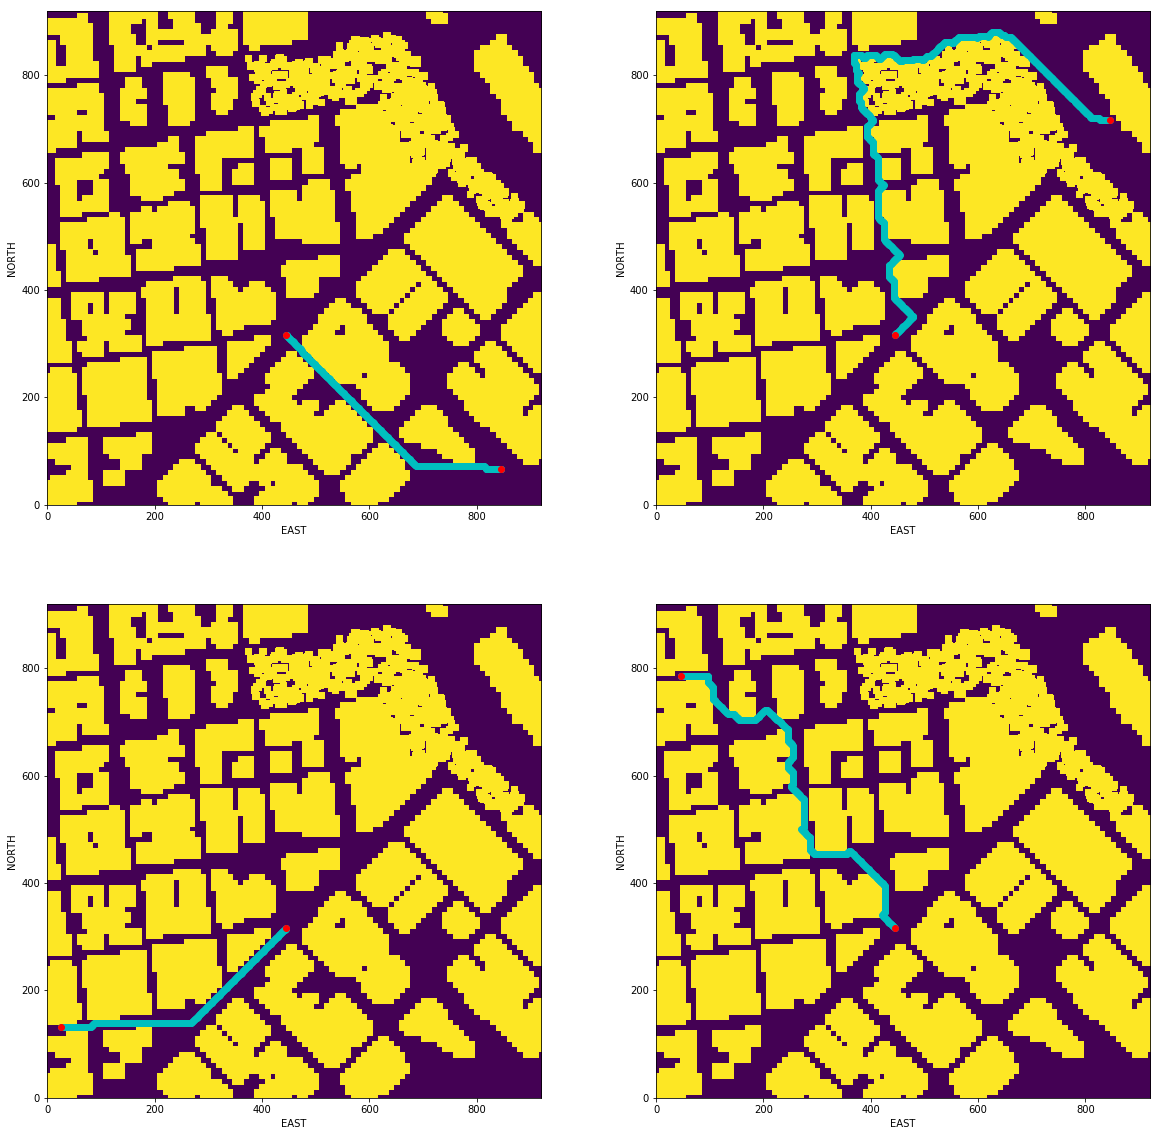

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
for ax, goal in zip(axes.flat, global_goals):
        start = time.time()
        goal_north, goal_east, _ = global_to_local(goal, global_home)
        goal_grid_north = int(np.ceil(goal_north) - north_offset)
        goal_grid_east = int(np.ceil(goal_east) - east_offset)
        goal_grid = (goal_grid_north, goal_grid_east)
        
        path, cost = a_star(grid, heuristic, grid_start, goal_grid)
        pruned_path = collinearity_prune(path)
        end = time.time()
        time_spam = end - start
        
        waypoints = np.array([[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path])
        waypoints_count = len(path)
        
        ax.imshow(grid, origin='lower') 
        
        ax.plot(grid_start[1] + waypoints[:, 1], grid_start[0] + waypoints[:, 0], 'g')
        ax.plot(grid_start[1] + waypoints[:, 1], grid_start[0] + waypoints[:, 0], 'oc')
        
        ax.plot(grid_start[1], grid_start[0], 'ro')
        ax.plot(goal_grid[1], goal_grid[0], 'ro')
        ax.set_xlabel('EAST')
        ax.set_ylabel('NORTH')
        print('Goal: ', goal, 'Cost: ', cost, 'Path Count: ', waypoints_count, 'Time: ', time_spam)